<a href="https://colab.research.google.com/github/LorenaGiVa/Caso---Marketing/blob/main/c_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact ## para análisis interactivo
from sklearn import neighbors ### basado en contenido un solo producto consumido
import joblib

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
## crear copia de db_books datos originales, nombrarla books2 y procesar books2
conn = sql.connect('/content/drive/MyDrive/Caso marketing analítica/data/db_movies2.db') ### crear cuando no existe el nombre de cd y para conectarse cuando sí existe.
cur = conn.cursor()

In [19]:
### para ver las tablas que hay en la base de datos
cur.execute("select name from sqlite_master where type='table' ")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('ratings_final',),
 ('full_ratings',)]

In [25]:
df = pd.read_sql("SELECT * FROM full_ratings", conn)
df

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995.0,2000-07-30
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995.0,2000-07-30
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995.0,2000-07-30
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995.0,2000-07-30
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995.0,2000-07-30
...,...,...,...,...,...,...,...,...
70524,609,892,3.0,Twelfth Night (1996),Comedy|Drama|Romance,Twelfth Night (1996),1996.0,1996-11-05
70525,609,1056,3.0,Jude (1996),Drama,Jude (1996),1996.0,1996-11-05
70526,609,1059,3.0,William Shakespeare's Romeo + Juliet (1996),Drama|Romance,William Shakespeare's Romeo + Juliet (1996),1996.0,1996-11-05
70527,609,1150,4.0,"Return of Martin Guerre, The (Retour de Martin...",Drama,"Return of Martin Guerre, The (Retour de Martin...",1982.0,1996-11-05


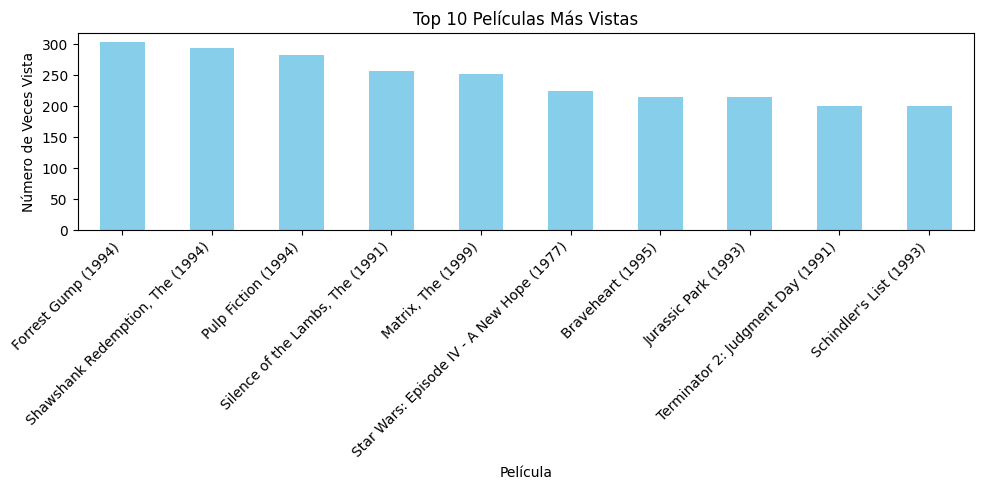

In [33]:
import matplotlib.pyplot as plt

# Agrupar por el título de la película y contar el número de ocurrencias
movie_views = df.groupby('movie_title')['user_id'].count().sort_values(ascending=False)

# Graficar el número de vistas por película
plt.figure(figsize=(10, 5))
movie_views.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Películas Más Vistas')
plt.xlabel('Película')
plt.ylabel('Número de Veces Vista')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Sistemas basados en popularidad

In [39]:
## peliculas vistas por más de 20 personas
pd.read_sql("""SELECT movie_title,
                avg(rating) as avg_rat,
                count(*) as movie_num
                FROM full_ratings
                WHERE rating <> 0
                GROUP BY movie_title
                HAVING count(*) >= 20
                ORDER BY avg_rat DESC, movie_num DESC
                LIMIT 10""", conn)

,movie_title,avg_rat,movie_num
0,"Shawshank Redemption, The (1994)",4.442177,294
1,"Manchurian Candidate, The (1962)",4.434783,23
2,Raging Bull (1980),4.403846,26
3,Hoop Dreams (1994),4.400000,25
4,Rosemary's Baby (1968),4.363636,22
5,Lawrence of Arabia (1962),4.319444,36
6,Cinema Paradiso (Nuovo cinema Paradiso) (1989),4.307692,26
7,In the Name of the Father (1993),4.300000,20
8,Cool Hand Luke (1967),4.287234,47
9,"Philadelphia Story, The (1940)",4.282609,23


In [50]:
#### los mejores calificados por año publicacion ###
pd.read_sql("""SELECT Año, movie_title, num_vistas
                FROM (
                    SELECT
                        strftime('%Y', fecha_nueva) AS Año,
                        movie_title,
                        ROW_NUMBER() OVER(PARTITION BY strftime('%Y', fecha_nueva) ORDER BY COUNT(*) DESC) AS row_num,
                        MAX(COUNT(*)) OVER(PARTITION BY strftime('%Y', fecha_nueva)) AS num_vistas
                    FROM full_ratings
                    GROUP BY strftime('%Y', fecha_nueva), movie_title) AS subquery
                WHERE row_num = 1
                ORDER BY Año;""", conn)

,Año,movie_title,num_vistas
0,1996,Batman (1989),83
1,1997,Independence Day (a.k.a. ID4) (1996),27
2,1998,Air Force One (1997),6
3,1999,Saving Private Ryan (1998),15
4,2000,American Beauty (1999),27
5,2001,Star Wars: Episode IV - A New Hope (1977),13
6,2002,"Silence of the Lambs, The (1991)",11
7,2003,"Lord of the Rings: The Two Towers, The (2002)",14
8,2004,Austin Powers: The Spy Who Shagged Me (1999),9
9,2005,"Sixth Sense, The (1999)",14


## Sistema de recomendación basado en contenido

In [54]:
peliculas = pd.read_sql("SELECT * FROM movies", conn)
peliculas

,movieId,title,genres,clean_title,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995.0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995.0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic,2017.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,2017.0
9739,193585,Flint (2017),Drama,Flint,2017.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,2018.0


In [55]:
peliculas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9742 non-null   int64  
 1   title        9742 non-null   object 
 2   genres       9742 non-null   object 
 3   clean_title  9730 non-null   object 
 4   year         9730 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 380.7+ KB
